# DEEP LEARNING PROJECT 1
---

In [1]:
%load_ext autoreload
%autoreload 2 
%matplotlib inline

import matplotlib.pyplot as plt
import torch.nn as nn
from torchsummary import summary
import torch
import torch.utils.data as data

## PARAMETERS

In [2]:
INPUT_SIZE = (2, 14, 14)

import torch.nn as nn
import numpy as np

NB_SAMPLES = 1000
DATA_DIR = './data'

NUMBER_OF_CLASSES = 10

WIDTH_HEIGHT = 14
SINGLE_IMAGE_SIZE = WIDTH_HEIGHT * WIDTH_HEIGHT
DOUBLE_IMAGE_SIZE = 2 * SINGLE_IMAGE_SIZE

# ----Train Config-----#
LEARNING_RATE = 0.001
TRAIN_BATCH_SIZE = 5
SUB_CRITERION = nn.CrossEntropyLoss()
FINAL_CRITERION = nn.BCELoss()
EPOCHS = 1

# ----AuxLoss Config-----#
ALPHA = 0.5

BEST_ALPHA_M = 0.22
BEST_ALPHA_O = 0

# ----Search Config-----#
KERNEL_SIZES = [3,5]
NB_CHANNELS = [4,8,16,24,48]
FCNEURONS = [32,64,128, 256,512]
NB_LAYERS = [1, 2, 3]
ALPHAS = np.linspace(0, 1, 10)

#----Test Config-----#
TEST_BATCH_SIZE = NB_SAMPLES

#----OscarNet Config-----#
OSCAR_NET_NAME = "oscar_net"
OSCAR_NET_HIDDEN_LAYER = 128
OSCAR_NET_NB_HIDDEN = 1

OSCAR_BEST_HIDDEN = 0

#----MaryJaneNet Config-----#
MARYJANE_NET_NAME = "maryjane_net"
MARYJANE_NET_HIDDEN_LAYER = 128
MARYJANE_NET_BASE_CHANNEL_SIZE = 8
MARYJANE_NET_NB_HIDDEN = 1
MARYJANE_NET_KERNEL_SIZE = 3

MARYJANE_BEST_HIDDEN = 64
MARYJANE_BEST_CHANNEL = 48
MARYJANE_BEST_KERNEL_SIZE = 3

#----DesmondNet Config-----#
DESMOND_NET_NAME = "desmond_net"
DESMOND_NET_HIDDEN_LAYER = 256
DESMOND_NET_NB_HIDDEN = 2

DESMOND_BEST_HIDDEN = 256

# Helpers

In [3]:
############################################# HELPERS ###############################

import torch
from torchvision import datasets
import os
import time
from pathlib import Path


######################################################################
# The data

def convert_to_one_hot_labels(input, target):
    tmp = input.new_zeros(target.size(0), target.max() + 1)
    #set ones
    tmp.scatter_(1, target.view(-1, 1), 1.0)
    return tmp

def load_data(cifar = None, one_hot_labels = False, normalize = False, flatten = True):

    data_dir = './data'

    if (cifar is not None and cifar):
        print('* Using CIFAR')
        cifar_train_set = datasets.CIFAR10(data_dir + '/cifar10/', train = True, download = True)
        cifar_test_set = datasets.CIFAR10(data_dir + '/cifar10/', train = False, download = True)

        train_input = torch.from_numpy(cifar_train_set.data)
        train_input = train_input.transpose(3, 1).transpose(2, 3).float()
        train_target = torch.tensor(cifar_train_set.targets, dtype = torch.int64)

        test_input = torch.from_numpy(cifar_test_set.data).float()
        test_input = test_input.transpose(3, 1).transpose(2, 3).float()
        test_target = torch.tensor(cifar_test_set.targets, dtype = torch.int64)

    else:
        print('* Using MNIST')
        mnist_train_set = datasets.MNIST(data_dir + '/mnist/', train = True, download = True)
        mnist_test_set = datasets.MNIST(data_dir + '/mnist/', train = False, download = True)

        train_input = mnist_train_set.data.view(-1, 1, 28, 28).float()
        train_target = mnist_train_set.targets
        test_input = mnist_test_set.data.view(-1, 1, 28, 28).float()
        test_target = mnist_test_set.targets

    if flatten:
        train_input = train_input.clone().reshape(train_input.size(0), -1)
        test_input = test_input.clone().reshape(test_input.size(0), -1)
        
        
    train_input = train_input.narrow(0, 0, 1000)
    train_target = train_target.narrow(0, 0, 1000)
    test_input = test_input.narrow(0, 0, 1000)
    test_target = test_target.narrow(0, 0, 1000)

    print('** Use {:d} train and {:d} test samples'.format(train_input.size(0), test_input.size(0)))

    if one_hot_labels:
        train_target = convert_to_one_hot_labels(train_input, train_target)
        test_target = convert_to_one_hot_labels(test_input, test_target)

    if normalize:
        mu, std = train_input.mean(), train_input.std()
        train_input.sub_(mu).div_(std)
        test_input.sub_(mu).div_(std)

    return train_input, train_target, test_input, test_target

######################################################################

def mnist_to_pairs(nb, input, target):
    input = torch.functional.F.avg_pool2d(input, kernel_size = 2)
    a = torch.randperm(input.size(0))
    a = a[:2 * nb].view(nb, 2)
    input = torch.cat((input[a[:, 0]], input[a[:, 1]]), 1)
    classes = target[a]
    target = (classes[:, 0] <= classes[:, 1]).long()
    return input, target, classes

######################################################################

def generate_pair_sets(nb):

    data_dir = DATA_DIR

    train_set = datasets.MNIST(data_dir + '/mnist/', train = True, download = True)
    train_input = train_set.data.view(-1, 1, 28, 28).float()
    train_target = train_set.targets

    test_set = datasets.MNIST(data_dir + '/mnist/', train = False, download = True)
    test_input = test_set.data.view(-1, 1, 28, 28).float()
    test_target = test_set.targets

    return mnist_to_pairs(nb, train_input, train_target) + \
           mnist_to_pairs(nb, test_input, test_target)

######################################################################

######################################################################

# Modules

In [4]:
import torch.nn as nn
import torch
from torch.nn import functional as F
import math
import config

class OscarNet(nn.Module):

    def __init__(self, nb_hidden_layers= OSCAR_NET_NB_HIDDEN, hidden_layer = OSCAR_NET_HIDDEN_LAYER):
        super(OscarNet, self).__init__()
        self.model_name = OSCAR_NET_NAME
        
        if nb_hidden_layers < 1:
            raise Exception("Minimum 1 hidden layers for " + self.model_name)
        
        self.hiddens = nn.ModuleList([nn.Sequential(nn.Linear(hidden_layer, hidden_layer), nn.LeakyReLU(), nn.Dropout(p=0.2)) for i in range(nb_hidden_layers-1)])

        self.hiddens.insert(0,nn.Sequential(nn.Linear(SINGLE_IMAGE_SIZE, hidden_layer), nn.LeakyReLU(), nn.Dropout(p=0.2)))
        
        self.output = nn.Linear(hidden_layer, NUMBER_OF_CLASSES)

    def forward(self, x):
        flattened = x.view(x.size(0),-1)
        
        hid = flattened
        
        for block in self.hiddens:
            hid = block(hid)
        
        out = self.output(hid)
        
        return F.softmax(out, dim=1), out

In [5]:
class MaryJaneNet(nn.Module):

    def __init__(self, nb_hidden_layers = MARYJANE_NET_NB_HIDDEN, base_channel_size = MARYJANE_NET_BASE_CHANNEL_SIZE, hidden_layer = config.MARYJANE_NET_HIDDEN_LAYER, kernel_size = MARYJANE_NET_KERNEL_SIZE):
        
        super(MaryJaneNet, self).__init__()
        self.model_name = MARYJANE_NET_NAME
        
        if nb_hidden_layers < 0:
             raise Exception("Minimum 0 hidden layers for " + self.model_name)
        
        self.base_channel_size = base_channel_size
        
        conv_channel_size = self.base_channel_size*2
        
        #(W−F+2P)/S+1
        #k= 1, 3, 5  
        self.conv_net = nn.Sequential(nn.Conv2d(1, self.base_channel_size, kernel_size= kernel_size ),  #(14-k)+1 = 15 -k # 14, 12,10
                                                 nn.LeakyReLU(),
                                                 nn.MaxPool2d(kernel_size=2, stride=2), #(15-k) / 2 : 7, 6, 5  
                                                 nn.Dropout(p=0.2),
                                                 nn.Conv2d(self.base_channel_size, conv_channel_size, 
                                                           kernel_size = kernel_size),    #7, 5, 3   # (15 - k) /2 - k + 1
                                                 nn.LeakyReLU(),
                                                 nn.Dropout(p=0.2) )

        fcn_input_size = int( ( ((15 - kernel_size) /2 - kernel_size + 1)** 2 ) * conv_channel_size)
        
        self.fc_net = nn.ModuleList()
        
        if nb_hidden_layers > 0:
            self.fc_net = nn.ModuleList([nn.Sequential(nn.Linear(hidden_layer, hidden_layer), nn.LeakyReLU(), nn.Dropout(p=0.2)) for i in range(nb_hidden_layers-1)])

            self.fc_net.insert(0,nn.Sequential(nn.Linear(fcn_input_size, hidden_layer), nn.LeakyReLU(), nn.Dropout(p=0.2)))

            self.output = nn.Linear(hidden_layer, NUMBER_OF_CLASSES)
            
        if nb_hidden_layers == 0:
            self.output = nn.Linear(fcn_input_size, NUMBER_OF_CLASSES)

    def forward(self, x):
        conved = self.conv_net(x)
        
        flattened = conved.view(conved.size(0),-1)
        
        hid = flattened
        
        for block in self.fc_net:
            hid = block(hid)
        
        out = self.output(hid)
        
        return F.softmax(out, dim=1), out

In [6]:
class DesmondNet(nn.Module):

    def __init__(self, left_net, right_net = None, nb_hidden_layers = DESMOND_NET_NB_HIDDEN, hidden_layer=DESMOND_NET_HIDDEN_LAYER, soft = False):
        super(DesmondNet, self).__init__()
        self.model_name = DESMOND_NET_NAME
        
        if nb_hidden_layers < 0:
            raise Exception("Minimum 0 hidden layers for " + self.model_name)
        
        self.subnets = nn.ModuleList([left_net])
        
        self.soft = soft
        
        if right_net == None :
            self.weight_sharing = True
        else :
            self.weight_sharing = False
            self.subnets.append(right_net)
        
        self.hiddens = nn.ModuleList()
        
        if nb_hidden_layers > 0:
            self.hiddens = nn.ModuleList([nn.Sequential(nn.Linear(hidden_layer, hidden_layer), nn.LeakyReLU(), nn.Dropout(p=0.2)) for i in range(nb_hidden_layers-1)])

            self.hiddens.insert(0,nn.Sequential(nn.Linear(config.NUMBER_OF_CLASSES*2, hidden_layer), nn.LeakyReLU(), nn.Dropout(p=0.2)))

            self.output = nn.Linear(hidden_layer, 1)
            
        if nb_hidden_layers == 0:
            self.output = nn.Linear(NUMBER_OF_CLASSES*2, 1)

    def forward(self, x):
        #SPLIT x which is of size [N, 2, 14, 14] to two distinct tensors of size [N, 1, 14, 14]
        input1 = x[:,0:1,:,:]   #(batch_size,1,14,14)
        input2 = x[:,1:2,:,:]   #(batch_size,1,14,14)
        
        lefted, lefted_no = self.subnets[0](input1)
        if self.weight_sharing :
            righted, righted_no = self.subnets[0](input2)
        else :
            righted, righted_no = self.subnets[1](input2)
        
        #CONCAT lefted and righted which are of size [N,10] each to a single tensor of size [N,20]
        if(self.soft):
            hid = torch.cat((lefted, righted),1)
        else:
            hid = torch.cat((lefted_no, righted_no),1)
        
        for block in self.hiddens:
            hid = block(hid)
        
        out = self.output(hid)
        
        return torch.sigmoid(out), lefted_no, righted_no

# Train & Predict

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.optim.lr_scheduler import StepLR

def train_siamese(model, 
                  dataloader, 
                  test_dataloader,
                  epochs = EPOCHS,
                  final_criterion = FINAL_CRITERION, 
                  learning_rate = LEARNING_RATE,
                  aux_loss = False,
                  sub_criterion = SUB_CRITERION, 
                  alpha = ALPHA):
    
    cuda = torch.cuda.is_available()
    if cuda:
        model = model.to(device="cuda")

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # gamma is the decaying factor, after every 1 epoch new_lr = lr*gamma 
    scheduler = StepLR(optimizer, step_size=1, gamma = 0.9)

    training_losses = []
    training_acc = []
    
    training_losses_l = []
    
    training_losses_r = []
    
    test_losses = []
    test_acc = []
    
    test_losses_l = []
    
    test_losses_r = []

    for epoch in range(1, epochs+1):  
        model.train()
        
        sum_loss_epoch = 0
        total = 0
        correct = 0
        accuracy_epoch = 0
        
        sum_loss_epoch_l = 0
        
        sum_loss_epoch_r = 0
        
        for ind_batch, sample_batched in enumerate(dataloader):
            
            images = sample_batched["images"]
            labels = sample_batched["bool_labels"]
            digit_labels = sample_batched["digit_labels"]
            
            labels = labels.unsqueeze(1)
            
            if cuda:
                images = images.to(device="cuda")
                labels = labels.to(device="cuda")
                digit_labels = digit_labels.to(device="cuda")

            optimizer.zero_grad()
                       
            output, lefted, righted = model(images)
            
            loss = final_criterion(output.flatten(), labels.float().flatten())
            loss_left = sub_criterion(lefted, digit_labels[:,0])
            loss_right = sub_criterion(righted, digit_labels[:,1])
            
            if aux_loss:
                loss = alpha * loss + ((1-alpha)/2) * loss_left + ((1-alpha)/2) * loss_right

            loss.require_grad = True
            loss.backward()

            optimizer.step()
            
            #update the accuracy 
            total += images.size(0)  
            correct += (output.round() == labels).sum() 
            
            # if ind_batch % 250 == 0:
                # print("[Epoch {}, Batch {}/{}]:  [Loss: {:.2f}]".format(epoch, ind_batch, len(dataloader), loss) )
                
            #add the loss for this batch to the total loss of the epoch
            sum_loss_epoch = sum_loss_epoch + loss.item()
            sum_loss_epoch_l = sum_loss_epoch_l + loss_left.item()
            sum_loss_epoch_r = sum_loss_epoch_r + loss_right.item()
            
        scheduler.step()
        #compute the mean to obtain the loss for this epoch 
        mean_loss = sum_loss_epoch / float(len(dataloader))
        mean_loss_l = sum_loss_epoch_l / float(len(dataloader))
        mean_loss_r = sum_loss_epoch_r / float(len(dataloader))
        
        # print("At epoch {0} the training loss is {1}".format(epoch, mean_loss) )
        training_losses.append(mean_loss)
        
        accuracy_epoch = float(correct) / float(total)
        # print("At epoch {0} the training accuracy is {1}".format(epoch, accuracy_epoch) )
        training_acc.append(accuracy_epoch)
        
        training_losses_l.append(mean_loss_l)
        training_losses_r.append(mean_loss_r)
        
#         print('epoch {0}/{1}'.format(epoch, epochs))
        
        test_loss, test_accuracy, test_loss_l, test_loss_r = predict_siamese(model,
                                                                     test_dataloader,
                                                                     final_criterion,
                                                                     aux_loss,
                                                                     sub_criterion,
                                                                     alpha)
        
        test_losses.append(test_loss)
        test_acc.append(test_accuracy)
        test_losses_l.append(test_loss_l)
        test_losses_r.append(test_loss_r)
        
    return training_losses, training_acc, training_losses_l, training_losses_r, test_losses, test_acc, test_losses_l, test_losses_r


def predict_siamese(model, 
            dataloader,
            final_criterion = FINAL_CRITERION,
            aux_loss = False,
            sub_criterion = SUB_CRITERION, 
            alpha = ALPHA):
    
    model.eval()
    
    cuda = torch.cuda.is_available()
    if cuda:
        model = model.to(device="cuda")
        
    sum_loss = 0
    total = 0
    correct = 0
    accuracy = 0

    sum_loss_l = 0

    sum_loss_r = 0

    for ind_batch, sample_batched in enumerate(dataloader):

        images = sample_batched["images"]
        labels = sample_batched["bool_labels"]
        digit_labels = sample_batched["digit_labels"]
        
        if cuda:
            images = images.to(device="cuda")
            labels = labels.to(device="cuda")
            digit_labels = digit_labels.to(device="cuda")

        output, lefted, righted = model(images)
        
        labels = labels.unsqueeze(1)

        loss = final_criterion(output.flatten(), labels.float().flatten())
        loss_left = sub_criterion(lefted, digit_labels[:,0])
        loss_right = sub_criterion(righted, digit_labels[:,1])

        if aux_loss:
            loss = alpha * loss + ((1-alpha)/2) * loss_left + ((1-alpha)/2) * loss_right

        #update the accuracy 
        total += images.size(0)  
        correct += (output.round() == labels).sum() 

        #add the loss for this batch to the total loss of the epoch
        sum_loss = sum_loss + loss.item()
        sum_loss_l = sum_loss_l + loss_left.item()
        sum_loss_r = sum_loss_r + loss_right.item()

    #compute the mean to obtain the loss for this epoch 
    mean_loss = sum_loss / float(len(dataloader))
    mean_loss_l = sum_loss_l / float(len(dataloader))
    mean_loss_r = sum_loss_r / float(len(dataloader))
    
    # print("The test loss is {0}".format(mean_loss) )

    accuracy = float(correct) / float(total)
    # print("The test accuracy is {0}".format(accuracy) )
        
    return mean_loss, accuracy, mean_loss_l, mean_loss_r

## Load Data

In [8]:
######## DATA #####################################################
import torch.utils.data as data
import matplotlib.pyplot as plt
import numpy as np

from torch.utils.data import Dataset


class PairDataset(Dataset):

    def __init__(self, data, bool_labels, digit_labels = None):
        self.images = data
        self.bool_labels = bool_labels
        
        if digit_labels is not None:
            self.digit_labels = digit_labels

    def __len__(self):
        # override the class method. return the length of data
        return len(self.bool_labels)

    def __getitem__(self, idx):
        # override the class method. return the item at the index(idx)
        if self.digit_labels is not None:
            sample = {"images" : self.images[idx],
                      "bool_labels" : self.bool_labels[idx],
                      "digit_labels" : self.digit_labels[idx]}
        else:
            sample = {"images" : self.images[idx],
                      "bool_labels" : self.bool_labels[idx]}
            
        return sample
    
class SingleDataset(Dataset):

    def __init__(self, data, digit_labels):
        self.images = data
        self.digit_labels = digit_labels

    def __len__(self):
        # override the class method. return the length of data
        return len(self.digit_labels)

    def __getitem__(self, idx):
        # override the class method. return the item at the index(idx)
        sample = {"images" : self.images[idx],
                  "digit_labels" : self.digit_labels[idx]}
            
        return sample

In [9]:
pairs = generate_pair_sets(NB_SAMPLES)

train_dataset = PairDataset(pairs[0], pairs[1], pairs[2])
train_dataloader = data.DataLoader(dataset=train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)

test_dataset = PairDataset(pairs[3], pairs[4], pairs[5])
test_dataloader = data.DataLoader(dataset=test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=True)

## Model 2: 
## Siamese FCNs - No weight sharing - No aux-loss

In [10]:
oscar21 = OscarNet(nb_hidden_layers = OSCAR_NET_NB_HIDDEN, 
                   hidden_layer = OSCAR_NET_HIDDEN_LAYER)

oscar22 = OscarNet(nb_hidden_layers = OSCAR_NET_NB_HIDDEN, 
                   hidden_layer = OSCAR_NET_HIDDEN_LAYER)

model2 = DesmondNet(oscar21, 
                    oscar22, 
                    nb_hidden_layers = DESMOND_NET_NB_HIDDEN, 
                    hidden_layer = DESMOND_NET_HIDDEN_LAYER)

In [11]:
summary(model2, INPUT_SIZE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]          25,216
         LeakyReLU-2                  [-1, 128]               0
           Dropout-3                  [-1, 128]               0
            Linear-4                   [-1, 10]           1,290
          OscarNet-5       [[-1, 10], [-1, 10]]               0
            Linear-6                  [-1, 128]          25,216
         LeakyReLU-7                  [-1, 128]               0
           Dropout-8                  [-1, 128]               0
            Linear-9                   [-1, 10]           1,290
         OscarNet-10       [[-1, 10], [-1, 10]]               0
           Linear-11                  [-1, 256]           5,376
        LeakyReLU-12                  [-1, 256]               0
          Dropout-13                  [-1, 256]               0
           Linear-14                  [

In [12]:
tr_loss2, tr_acc2, tr_loss2_l, tr_loss2_r, te_loss2, te_acc2, te_loss2_l, te_loss2_r = train_siamese(model = model2,
                                     dataloader = train_dataloader,
                                     test_dataloader = test_dataloader,
                                     epochs = EPOCHS,
                                     final_criterion = FINAL_CRITERION, 
                                     learning_rate = LEARNING_RATE)

Text(0.5, 1.0, 'Training loss (right brother)')

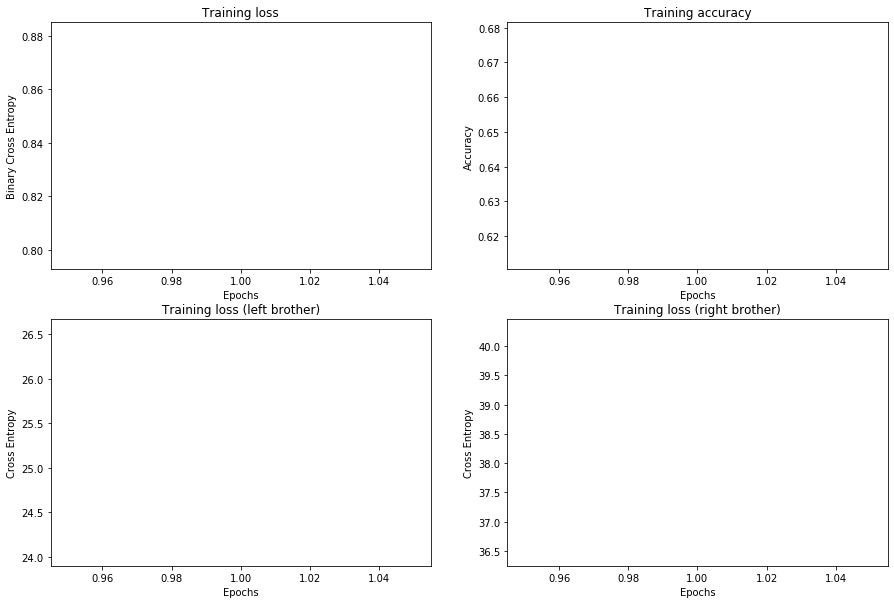

In [13]:
plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
plt.plot(range(1, EPOCHS+1), tr_loss2)
plt.xlabel('Epochs')
plt.ylabel('Binary Cross Entropy')
plt.title('Training loss')

plt.subplot(2,2,2)
plt.plot(range(1, EPOCHS+1), tr_acc2)
plt.title('Training accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.subplot(2,2,3)
plt.plot(range(1, EPOCHS+1), tr_loss2_l)
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy')
plt.title('Training loss (left brother)')

plt.subplot(2,2,4)
plt.plot(range(1, EPOCHS+1), tr_loss2_r)
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy')
plt.title('Training loss (right brother)')

Last test accuracy :0.765


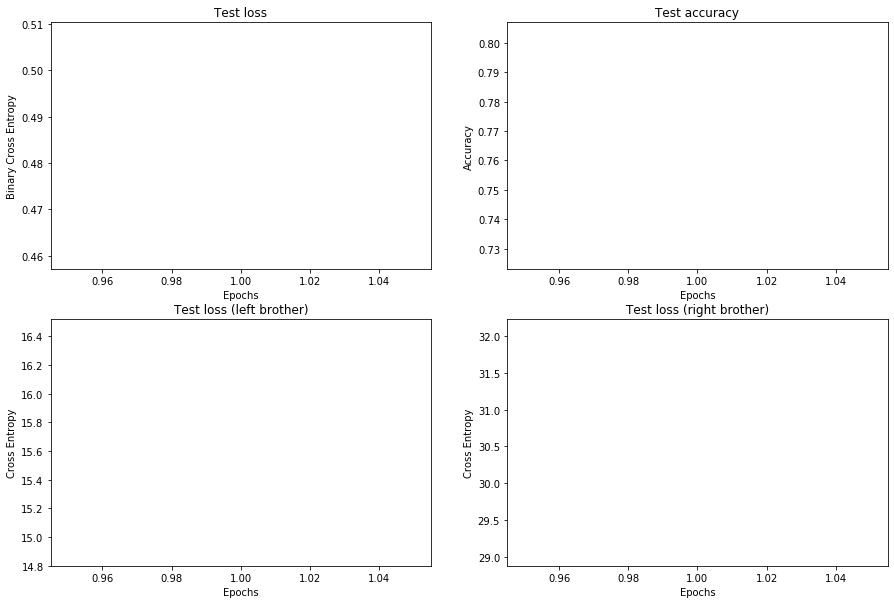

In [14]:
plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
plt.plot(range(1, EPOCHS+1), te_loss2)
plt.xlabel('Epochs')
plt.ylabel('Binary Cross Entropy')
plt.title('Test loss')

plt.subplot(2,2,2)
plt.plot(range(1, EPOCHS+1), te_acc2)
plt.title('Test accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.subplot(2,2,3)
plt.plot(range(1, EPOCHS+1), te_loss2_l)
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy')
plt.title('Test loss (left brother)')

plt.subplot(2,2,4)
plt.plot(range(1, EPOCHS+1), te_loss2_r)
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy')
plt.title('Test loss (right brother)')

print("Last test accuracy :" + str(te_acc2[-1]))

## Model 3: 
## Siamese FCNs - No weight sharing - Aux-loss

In [15]:
oscar31 = OscarNet(nb_hidden_layers = OSCAR_NET_NB_HIDDEN, 
                   hidden_layer = OSCAR_NET_HIDDEN_LAYER)

oscar32 = OscarNet(nb_hidden_layers = OSCAR_NET_NB_HIDDEN, 
                   hidden_layer = OSCAR_NET_HIDDEN_LAYER)

model3 = DesmondNet(oscar31, 
                    oscar32, 
                    nb_hidden_layers = DESMOND_NET_NB_HIDDEN, 
                    hidden_layer = DESMOND_NET_HIDDEN_LAYER)

In [16]:
summary(model3, INPUT_SIZE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]          25,216
         LeakyReLU-2                  [-1, 128]               0
           Dropout-3                  [-1, 128]               0
            Linear-4                   [-1, 10]           1,290
          OscarNet-5       [[-1, 10], [-1, 10]]               0
            Linear-6                  [-1, 128]          25,216
         LeakyReLU-7                  [-1, 128]               0
           Dropout-8                  [-1, 128]               0
            Linear-9                   [-1, 10]           1,290
         OscarNet-10       [[-1, 10], [-1, 10]]               0
           Linear-11                  [-1, 256]           5,376
        LeakyReLU-12                  [-1, 256]               0
          Dropout-13                  [-1, 256]               0
           Linear-14                  [

In [17]:
tr_loss3, tr_acc3, tr_loss3_l, tr_loss3_r, te_loss3, te_acc3, te_loss3_l, te_loss3_r = train_siamese(model = model3,
                                     dataloader = train_dataloader,
                                     test_dataloader = test_dataloader,
                                     epochs = EPOCHS,
                                     final_criterion = FINAL_CRITERION, 
                                     learning_rate = LEARNING_RATE,
                                     aux_loss = True,
                                     sub_criterion = SUB_CRITERION, 
                                     alpha = ALPHA)

Text(0.5, 1.0, 'Training loss (right brother)')

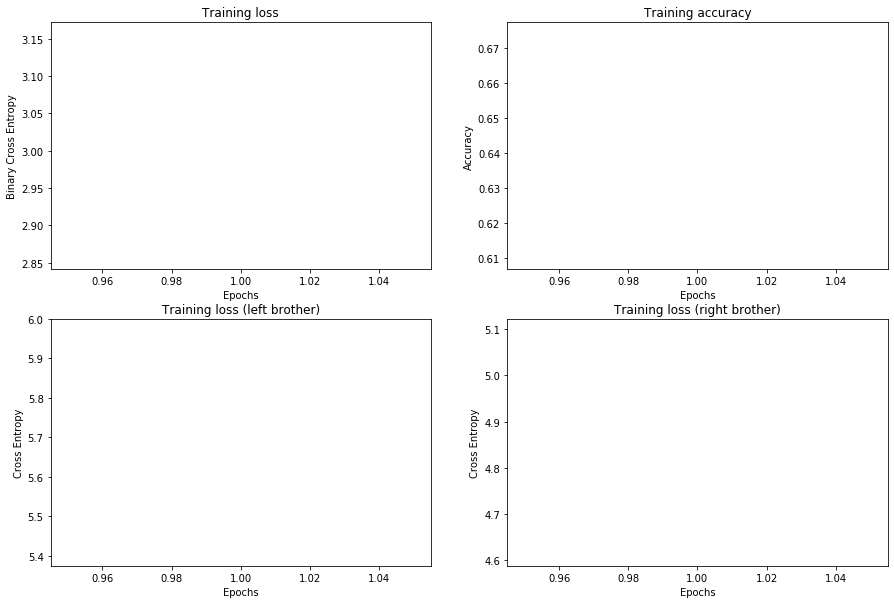

In [18]:
plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
plt.plot(range(1, EPOCHS+1), tr_loss3)
plt.xlabel('Epochs')
plt.ylabel('Binary Cross Entropy')
plt.title('Training loss')

plt.subplot(2,2,2)
plt.plot(range(1, EPOCHS+1), tr_acc3)
plt.title('Training accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.subplot(2,2,3)
plt.plot(range(1, EPOCHS+1), tr_loss3_l)
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy')
plt.title('Training loss (left brother)')

plt.subplot(2,2,4)
plt.plot(range(1, EPOCHS+1), tr_loss3_r)
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy')
plt.title('Training loss (right brother)')

Last test accuracy :0.771


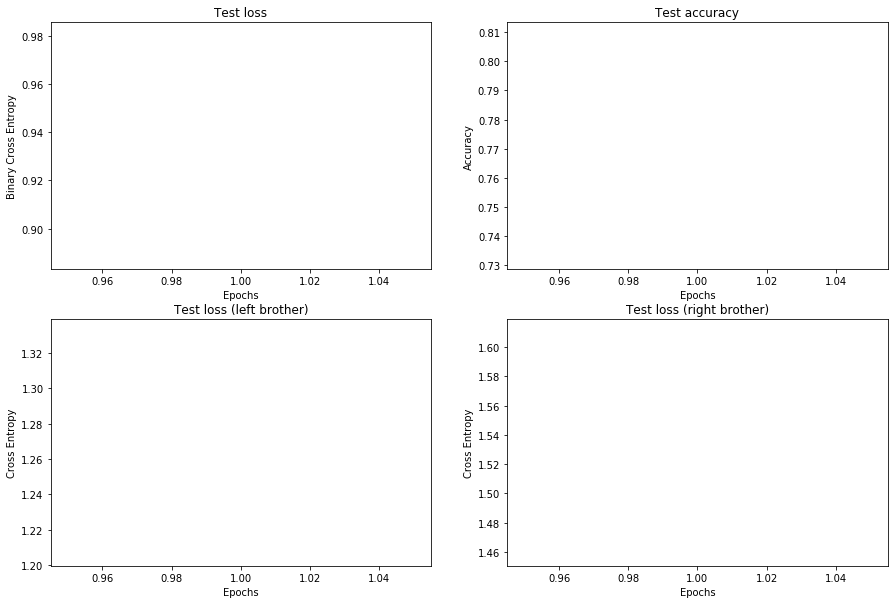

In [19]:
plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
plt.plot(range(1, EPOCHS+1), te_loss3)
plt.xlabel('Epochs')
plt.ylabel('Binary Cross Entropy')
plt.title('Test loss')

plt.subplot(2,2,2)
plt.plot(range(1, EPOCHS+1), te_acc3)
plt.title('Test accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.subplot(2,2,3)
plt.plot(range(1, EPOCHS+1), te_loss3_l)
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy')
plt.title('Test loss (left brother)')

plt.subplot(2,2,4)
plt.plot(range(1, EPOCHS+1), te_loss3_r)
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy')
plt.title('Test loss (right brother)')

print("Last test accuracy :" + str(te_acc3[-1]))

## Model 4: 
## Siamese CNNs - No weight sharing - No aux-loss

In [20]:
maryjane41 = MaryJaneNet(nb_hidden_layers = MARYJANE_NET_NB_HIDDEN, 
                         hidden_layer = MARYJANE_NET_HIDDEN_LAYER, 
                         base_channel_size = MARYJANE_NET_BASE_CHANNEL_SIZE, 
                         kernel_size = MARYJANE_NET_KERNEL_SIZE)

maryjane42 = MaryJaneNet(nb_hidden_layers = MARYJANE_NET_NB_HIDDEN, 
                         hidden_layer = MARYJANE_NET_HIDDEN_LAYER, 
                         base_channel_size = MARYJANE_NET_BASE_CHANNEL_SIZE, 
                         kernel_size = MARYJANE_NET_KERNEL_SIZE)

model4 = DesmondNet(maryjane41, 
                    maryjane42, 
                    nb_hidden_layers = DESMOND_NET_NB_HIDDEN, 
                    hidden_layer = DESMOND_NET_HIDDEN_LAYER)

In [21]:
summary(model4, INPUT_SIZE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 12, 12]              80
         LeakyReLU-2            [-1, 8, 12, 12]               0
         MaxPool2d-3              [-1, 8, 6, 6]               0
           Dropout-4              [-1, 8, 6, 6]               0
            Conv2d-5             [-1, 16, 4, 4]           1,168
         LeakyReLU-6             [-1, 16, 4, 4]               0
           Dropout-7             [-1, 16, 4, 4]               0
            Linear-8                  [-1, 128]          32,896
         LeakyReLU-9                  [-1, 128]               0
          Dropout-10                  [-1, 128]               0
           Linear-11                   [-1, 10]           1,290
      MaryJaneNet-12       [[-1, 10], [-1, 10]]               0
           Conv2d-13            [-1, 8, 12, 12]              80
        LeakyReLU-14            [-1, 8,

In [22]:
tr_loss4, tr_acc4, tr_loss4_l, tr_loss4_r, te_loss4, te_acc4, te_loss4_l, te_loss4_r = train_siamese(model = model4,
                                     dataloader = train_dataloader,
                                     test_dataloader = test_dataloader,
                                     epochs = EPOCHS,
                                     final_criterion = FINAL_CRITERION, 
                                     learning_rate = LEARNING_RATE)

Text(0.5, 1.0, 'Training loss (right brother)')

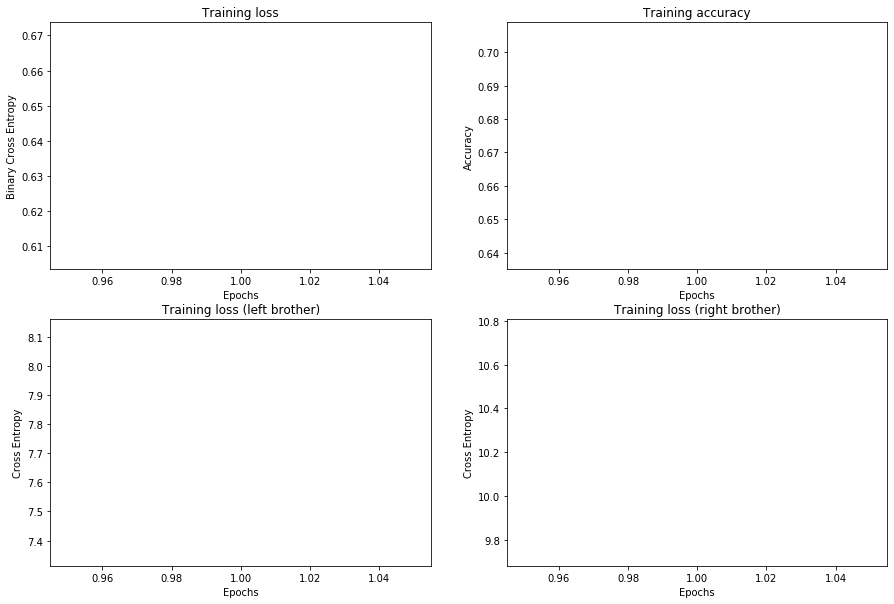

In [23]:
plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
plt.plot(range(1, EPOCHS+1), tr_loss4)
plt.xlabel('Epochs')
plt.ylabel('Binary Cross Entropy')
plt.title('Training loss')

plt.subplot(2,2,2)
plt.plot(range(1, EPOCHS+1), tr_acc4)
plt.title('Training accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.subplot(2,2,3)
plt.plot(range(1, EPOCHS+1), tr_loss4_l)
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy')
plt.title('Training loss (left brother)')

plt.subplot(2,2,4)
plt.plot(range(1, EPOCHS+1), tr_loss4_r)
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy')
plt.title('Training loss (right brother)')

Last test accuracy :0.755


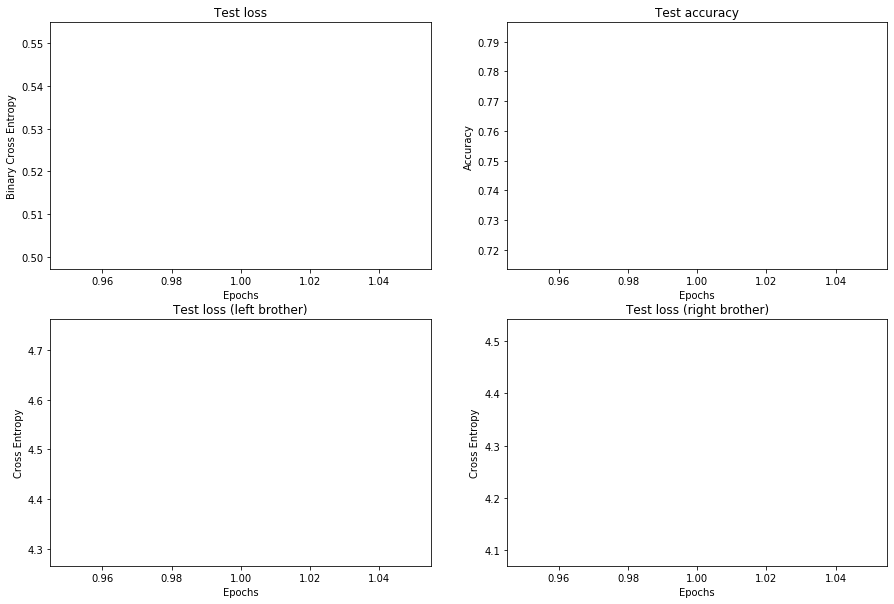

In [24]:
plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
plt.plot(range(1, EPOCHS+1), te_loss4)
plt.xlabel('Epochs')
plt.ylabel('Binary Cross Entropy')
plt.title('Test loss')

plt.subplot(2,2,2)
plt.plot(range(1, EPOCHS+1), te_acc4)
plt.title('Test accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.subplot(2,2,3)
plt.plot(range(1, EPOCHS+1), te_loss4_l)
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy')
plt.title('Test loss (left brother)')

plt.subplot(2,2,4)
plt.plot(range(1, EPOCHS+1), te_loss4_r)
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy')
plt.title('Test loss (right brother)')

print("Last test accuracy :" + str(te_acc4[-1]))

## Model 5: 
## Siamese CNNs - No weight sharing - Aux-loss

In [25]:
maryjane51 = MaryJaneNet(nb_hidden_layers = MARYJANE_NET_NB_HIDDEN, 
                         hidden_layer = MARYJANE_NET_HIDDEN_LAYER, 
                         base_channel_size = MARYJANE_NET_BASE_CHANNEL_SIZE, 
                         kernel_size = MARYJANE_NET_KERNEL_SIZE)

maryjane52 = MaryJaneNet(nb_hidden_layers = MARYJANE_NET_NB_HIDDEN, 
                         hidden_layer = MARYJANE_NET_HIDDEN_LAYER, 
                         base_channel_size = MARYJANE_NET_BASE_CHANNEL_SIZE, 
                         kernel_size = MARYJANE_NET_KERNEL_SIZE)

model5 = DesmondNet(maryjane51, 
                    maryjane52, 
                    nb_hidden_layers = DESMOND_NET_NB_HIDDEN, 
                    hidden_layer = DESMOND_NET_HIDDEN_LAYER)

In [26]:
summary(model5, INPUT_SIZE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 12, 12]              80
         LeakyReLU-2            [-1, 8, 12, 12]               0
         MaxPool2d-3              [-1, 8, 6, 6]               0
           Dropout-4              [-1, 8, 6, 6]               0
            Conv2d-5             [-1, 16, 4, 4]           1,168
         LeakyReLU-6             [-1, 16, 4, 4]               0
           Dropout-7             [-1, 16, 4, 4]               0
            Linear-8                  [-1, 128]          32,896
         LeakyReLU-9                  [-1, 128]               0
          Dropout-10                  [-1, 128]               0
           Linear-11                   [-1, 10]           1,290
      MaryJaneNet-12       [[-1, 10], [-1, 10]]               0
           Conv2d-13            [-1, 8, 12, 12]              80
        LeakyReLU-14            [-1, 8,

In [27]:
tr_loss5, tr_acc5, tr_loss5_l, tr_loss5_r, te_loss5, te_acc5, te_loss5_l, te_loss5_r = train_siamese(model = model5,
                                     dataloader = train_dataloader,
                                     test_dataloader = test_dataloader,
                                     epochs = EPOCHS,
                                     final_criterion = FINAL_CRITERION, 
                                     learning_rate = LEARNING_RATE,
                                     aux_loss = True,
                                     sub_criterion = SUB_CRITERION, 
                                     alpha = ALPHA)

Text(0.5, 1.0, 'Training loss (right brother)')

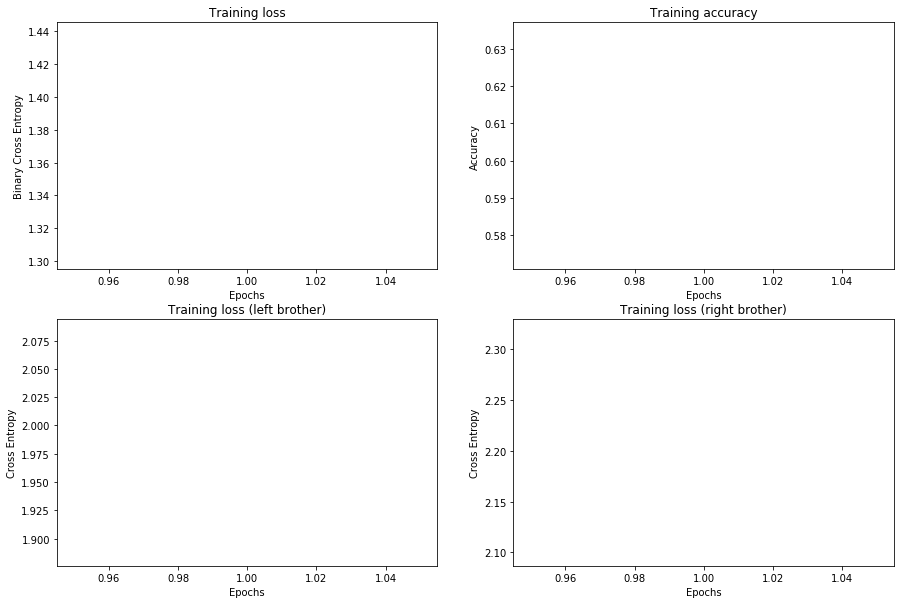

In [28]:
plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
plt.plot(range(1, EPOCHS+1), tr_loss5)
plt.xlabel('Epochs')
plt.ylabel('Binary Cross Entropy')
plt.title('Training loss')

plt.subplot(2,2,2)
plt.plot(range(1, EPOCHS+1), tr_acc5)
plt.title('Training accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.subplot(2,2,3)
plt.plot(range(1, EPOCHS+1), tr_loss5_l)
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy')
plt.title('Training loss (left brother)')

plt.subplot(2,2,4)
plt.plot(range(1, EPOCHS+1), tr_loss5_r)
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy')
plt.title('Training loss (right brother)')

Last test accuracy :0.751


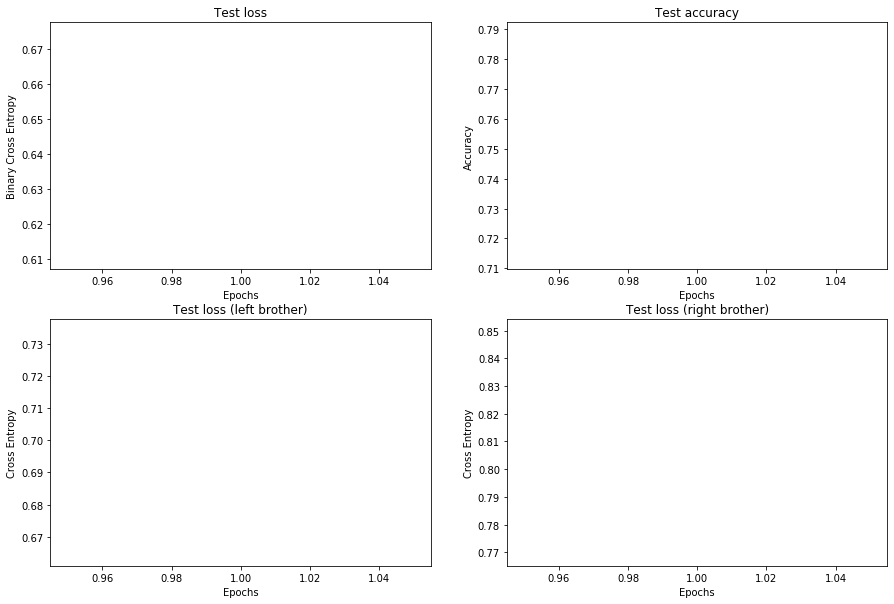

In [29]:
plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
plt.plot(range(1, EPOCHS+1), te_loss5)
plt.xlabel('Epochs')
plt.ylabel('Binary Cross Entropy')
plt.title('Test loss')

plt.subplot(2,2,2)
plt.plot(range(1, EPOCHS+1), te_acc5)
plt.title('Test accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.subplot(2,2,3)
plt.plot(range(1, EPOCHS+1), te_loss5_l)
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy')
plt.title('Test loss (left brother)')

plt.subplot(2,2,4)
plt.plot(range(1, EPOCHS+1), te_loss5_r)
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy')
plt.title('Test loss (right brother)')

print("Last test accuracy :" + str(te_acc5[-1]))

## Model 6: 
## Siamese FCNs - Weight sharing - No aux-loss

In [30]:
oscar6 = OscarNet(nb_hidden_layers = OSCAR_NET_NB_HIDDEN, 
                  hidden_layer = OSCAR_NET_HIDDEN_LAYER)

model6 = DesmondNet(oscar6, 
                    nb_hidden_layers = DESMOND_NET_NB_HIDDEN, 
                    hidden_layer = DESMOND_NET_HIDDEN_LAYER)

In [31]:
summary(model6, INPUT_SIZE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]          25,216
         LeakyReLU-2                  [-1, 128]               0
           Dropout-3                  [-1, 128]               0
            Linear-4                   [-1, 10]           1,290
          OscarNet-5       [[-1, 10], [-1, 10]]               0
            Linear-6                  [-1, 128]          25,216
         LeakyReLU-7                  [-1, 128]               0
           Dropout-8                  [-1, 128]               0
            Linear-9                   [-1, 10]           1,290
         OscarNet-10       [[-1, 10], [-1, 10]]               0
           Linear-11                  [-1, 256]           5,376
        LeakyReLU-12                  [-1, 256]               0
          Dropout-13                  [-1, 256]               0
           Linear-14                  [

In [32]:
tr_loss6, tr_acc6, tr_loss6_l, tr_loss6_r, te_loss6, te_acc6, te_loss6_l, te_loss6_r = train_siamese(model = model6,
                                     dataloader = train_dataloader,
                                     test_dataloader = test_dataloader,
                                     epochs = EPOCHS,
                                     final_criterion = FINAL_CRITERION, 
                                     learning_rate = LEARNING_RATE)

Text(0.5, 1.0, 'Training loss (right brother)')

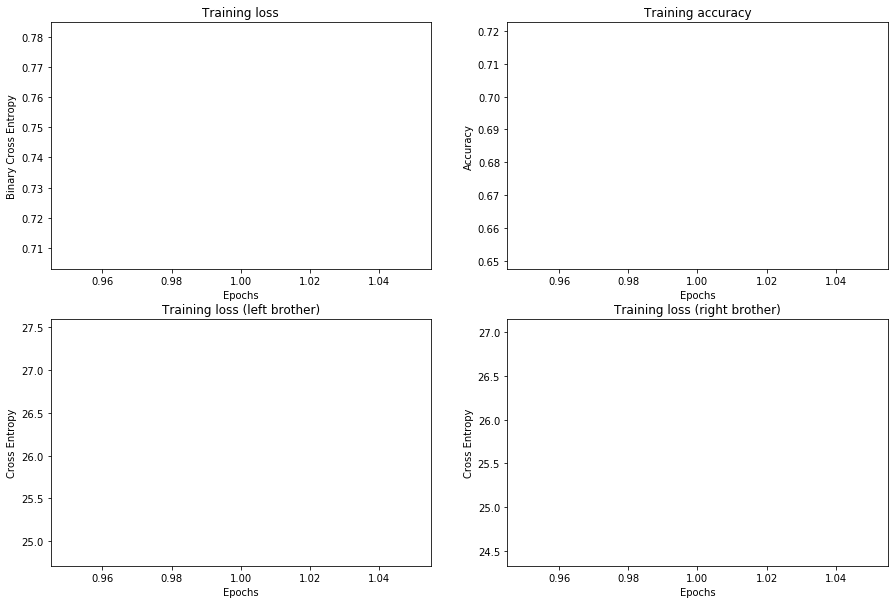

In [33]:
plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
plt.plot(range(1, EPOCHS+1), tr_loss6)
plt.xlabel('Epochs')
plt.ylabel('Binary Cross Entropy')
plt.title('Training loss')

plt.subplot(2,2,2)
plt.plot(range(1, EPOCHS+1), tr_acc6)
plt.title('Training accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.subplot(2,2,3)
plt.plot(range(1, EPOCHS+1), tr_loss6_l)
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy')
plt.title('Training loss (left brother)')

plt.subplot(2,2,4)
plt.plot(range(1, EPOCHS+1), tr_loss6_r)
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy')
plt.title('Training loss (right brother)')

Last test accuracy :0.774


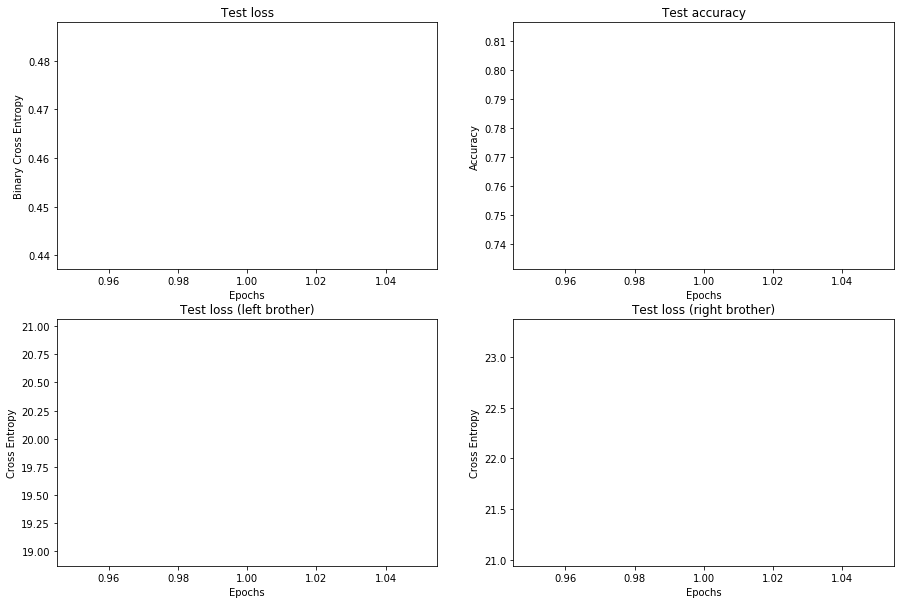

In [34]:
plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
plt.plot(range(1, EPOCHS+1), te_loss6)
plt.xlabel('Epochs')
plt.ylabel('Binary Cross Entropy')
plt.title('Test loss')

plt.subplot(2,2,2)
plt.plot(range(1, EPOCHS+1), te_acc6)
plt.title('Test accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.subplot(2,2,3)
plt.plot(range(1, EPOCHS+1), te_loss6_l)
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy')
plt.title('Test loss (left brother)')

plt.subplot(2,2,4)
plt.plot(range(1, EPOCHS+1), te_loss6_r)
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy')
plt.title('Test loss (right brother)')

print("Last test accuracy :" + str(te_acc6[-1]))

## Model 7: 
## Siamese FCNs - Weight sharing - Aux-loss

In [35]:
oscar7 = OscarNet(nb_hidden_layers = OSCAR_NET_NB_HIDDEN, 
                  hidden_layer = OSCAR_NET_HIDDEN_LAYER)

model7 = DesmondNet(oscar7, 
                    nb_hidden_layers = OSCAR_NET_NB_HIDDEN, 
                    hidden_layer = OSCAR_NET_HIDDEN_LAYER)

In [36]:
summary(model7, INPUT_SIZE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]          25,216
         LeakyReLU-2                  [-1, 128]               0
           Dropout-3                  [-1, 128]               0
            Linear-4                   [-1, 10]           1,290
          OscarNet-5       [[-1, 10], [-1, 10]]               0
            Linear-6                  [-1, 128]          25,216
         LeakyReLU-7                  [-1, 128]               0
           Dropout-8                  [-1, 128]               0
            Linear-9                   [-1, 10]           1,290
         OscarNet-10       [[-1, 10], [-1, 10]]               0
           Linear-11                  [-1, 128]           2,688
        LeakyReLU-12                  [-1, 128]               0
          Dropout-13                  [-1, 128]               0
           Linear-14                   

In [37]:
tr_loss7, tr_acc7, tr_loss7_l, tr_loss7_r, te_loss7, te_acc7, te_loss7_l, te_loss7_r = train_siamese(model = model7,
                                     dataloader = train_dataloader,
                                     test_dataloader = test_dataloader,
                                     epochs = EPOCHS,
                                     final_criterion = FINAL_CRITERION, 
                                     learning_rate = LEARNING_RATE,
                                     aux_loss = True,
                                     sub_criterion = SUB_CRITERION, 
                                     alpha = ALPHA)

Text(0.5, 1.0, 'Training loss (right brother)')

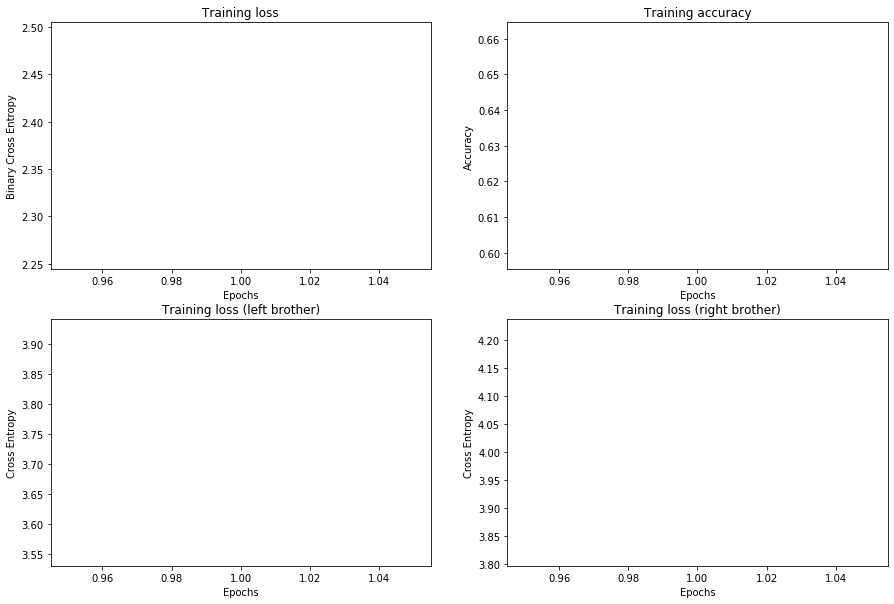

In [38]:
plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
plt.plot(range(1, EPOCHS+1), tr_loss7)
plt.xlabel('Epochs')
plt.ylabel('Binary Cross Entropy')
plt.title('Training loss')

plt.subplot(2,2,2)
plt.plot(range(1, EPOCHS+1), tr_acc7)
plt.title('Training accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.subplot(2,2,3)
plt.plot(range(1, EPOCHS+1), tr_loss7_l)
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy')
plt.title('Training loss (left brother)')

plt.subplot(2,2,4)
plt.plot(range(1, EPOCHS+1), tr_loss7_r)
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy')
plt.title('Training loss (right brother)')

Last test accuracy :0.762


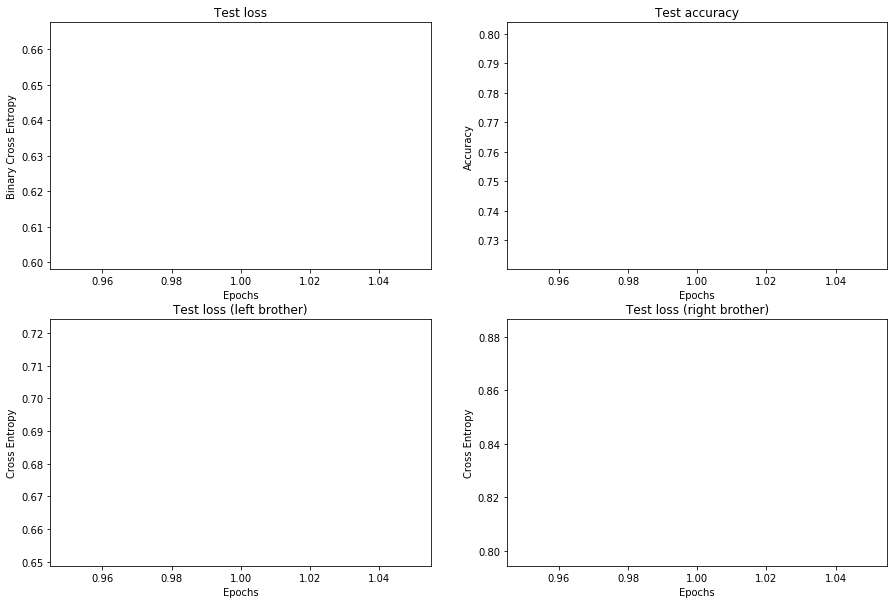

In [39]:
plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
plt.plot(range(1, EPOCHS+1), te_loss7)
plt.xlabel('Epochs')
plt.ylabel('Binary Cross Entropy')
plt.title('Test loss')

plt.subplot(2,2,2)
plt.plot(range(1, EPOCHS+1), te_acc7)
plt.title('Test accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.subplot(2,2,3)
plt.plot(range(1, EPOCHS+1), te_loss7_l)
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy')
plt.title('Test loss (left brother)')

plt.subplot(2,2,4)
plt.plot(range(1, EPOCHS+1), te_loss7_r)
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy')
plt.title('Test loss (right brother)')

print("Last test accuracy :" + str(te_acc7[-1]))

## Model 8: 
## Siamese CNNs - Weight sharing - No aux-loss

In [40]:
maryjane8 = MaryJaneNet(nb_hidden_layers = MARYJANE_NET_NB_HIDDEN, 
                       hidden_layer = MARYJANE_NET_HIDDEN_LAYER, 
                       base_channel_size = MARYJANE_NET_BASE_CHANNEL_SIZE, 
                       kernel_size = MARYJANE_NET_KERNEL_SIZE)

model8 = DesmondNet(maryjane8, 
                    nb_hidden_layers = DESMOND_NET_NB_HIDDEN, 
                    hidden_layer = DESMOND_NET_HIDDEN_LAYER)

In [41]:
summary(model8, INPUT_SIZE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 12, 12]              80
         LeakyReLU-2            [-1, 8, 12, 12]               0
         MaxPool2d-3              [-1, 8, 6, 6]               0
           Dropout-4              [-1, 8, 6, 6]               0
            Conv2d-5             [-1, 16, 4, 4]           1,168
         LeakyReLU-6             [-1, 16, 4, 4]               0
           Dropout-7             [-1, 16, 4, 4]               0
            Linear-8                  [-1, 128]          32,896
         LeakyReLU-9                  [-1, 128]               0
          Dropout-10                  [-1, 128]               0
           Linear-11                   [-1, 10]           1,290
      MaryJaneNet-12       [[-1, 10], [-1, 10]]               0
           Conv2d-13            [-1, 8, 12, 12]              80
        LeakyReLU-14            [-1, 8,

In [42]:
tr_loss8, tr_acc8, tr_loss8_l, tr_loss8_r, te_loss8, te_acc8, te_loss8_l, te_loss8_r = train_siamese(model = model8,
                                     dataloader = train_dataloader,
                                     test_dataloader = test_dataloader,
                                     epochs = EPOCHS,
                                     final_criterion = FINAL_CRITERION, 
                                     learning_rate = LEARNING_RATE)

Text(0.5, 1.0, 'Training loss (right brother)')

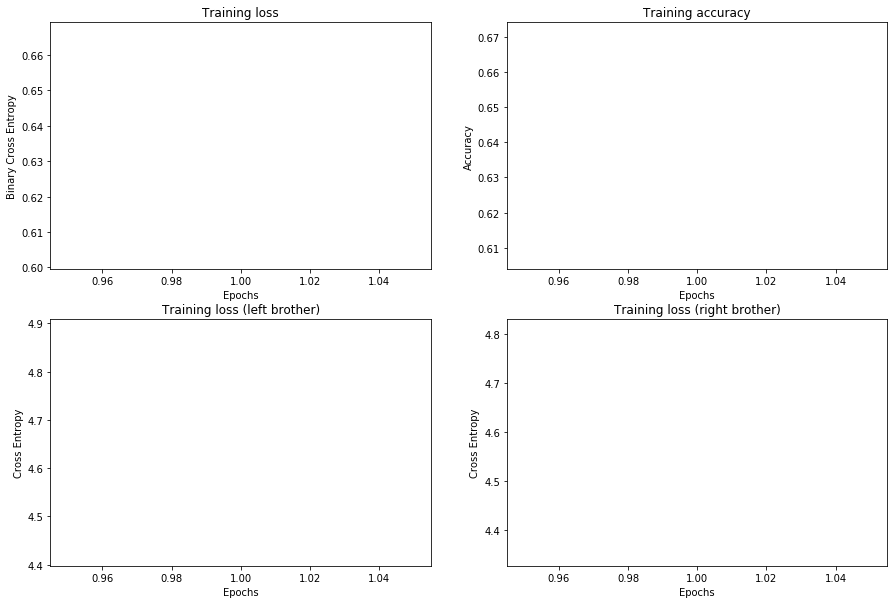

In [43]:
plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
plt.plot(range(1, EPOCHS+1), tr_loss8)
plt.xlabel('Epochs')
plt.ylabel('Binary Cross Entropy')
plt.title('Training loss')

plt.subplot(2,2,2)
plt.plot(range(1, EPOCHS+1), tr_acc8)
plt.title('Training accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.subplot(2,2,3)
plt.plot(range(1, EPOCHS+1), tr_loss8_l)
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy')
plt.title('Training loss (left brother)')

plt.subplot(2,2,4)
plt.plot(range(1, EPOCHS+1), tr_loss8_r)
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy')
plt.title('Training loss (right brother)')

Last test accuracy :0.76


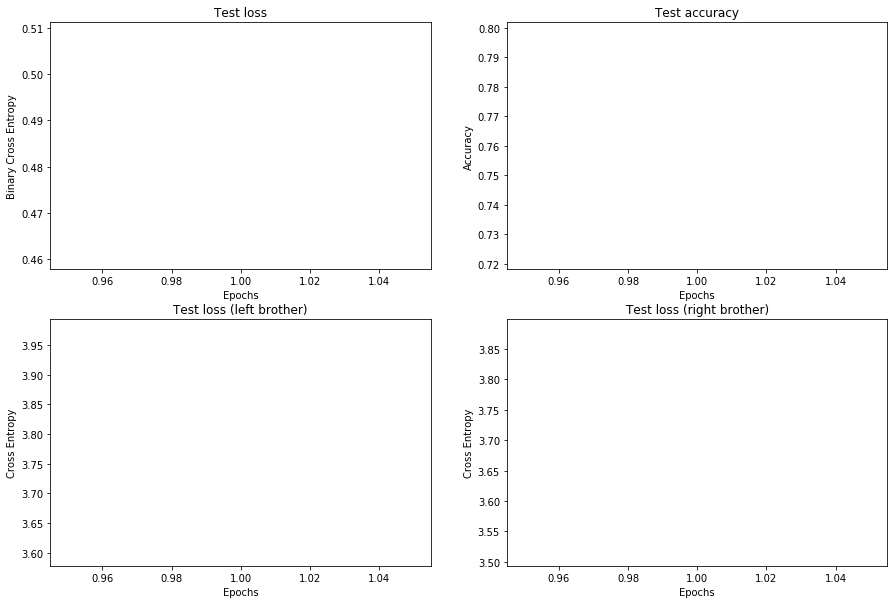

In [44]:
plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
plt.plot(range(1, EPOCHS+1), te_loss8)
plt.xlabel('Epochs')
plt.ylabel('Binary Cross Entropy')
plt.title('Test loss')

plt.subplot(2,2,2)
plt.plot(range(1, EPOCHS+1), te_acc8)
plt.title('Test accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.subplot(2,2,3)
plt.plot(range(1, EPOCHS+1), te_loss8_l)
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy')
plt.title('Test loss (left brother)')

plt.subplot(2,2,4)
plt.plot(range(1, EPOCHS+1), te_loss8_r)
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy')
plt.title('Test loss (right brother)')

print("Last test accuracy :" + str(te_acc8[-1]))

## Model 9: 
## Siamese CNNs - Weight sharing - Aux-loss

In [45]:
maryjane9 = MaryJaneNet(nb_hidden_layers = MARYJANE_NET_NB_HIDDEN, 
                       hidden_layer = MARYJANE_NET_HIDDEN_LAYER, 
                       base_channel_size = MARYJANE_NET_BASE_CHANNEL_SIZE, 
                       kernel_size = MARYJANE_NET_KERNEL_SIZE)

model9 = DesmondNet(maryjane9, 
                    nb_hidden_layers = DESMOND_NET_NB_HIDDEN, 
                    hidden_layer = DESMOND_NET_HIDDEN_LAYER)

In [46]:
summary(model9, INPUT_SIZE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 12, 12]              80
         LeakyReLU-2            [-1, 8, 12, 12]               0
         MaxPool2d-3              [-1, 8, 6, 6]               0
           Dropout-4              [-1, 8, 6, 6]               0
            Conv2d-5             [-1, 16, 4, 4]           1,168
         LeakyReLU-6             [-1, 16, 4, 4]               0
           Dropout-7             [-1, 16, 4, 4]               0
            Linear-8                  [-1, 128]          32,896
         LeakyReLU-9                  [-1, 128]               0
          Dropout-10                  [-1, 128]               0
           Linear-11                   [-1, 10]           1,290
      MaryJaneNet-12       [[-1, 10], [-1, 10]]               0
           Conv2d-13            [-1, 8, 12, 12]              80
        LeakyReLU-14            [-1, 8,

In [47]:
tr_loss9, tr_acc9, tr_loss9_l, tr_loss9_r, te_loss9, te_acc9, te_loss9_l, te_loss9_r = train_siamese(model = model9,
                                     dataloader = train_dataloader,
                                     test_dataloader = test_dataloader,
                                     epochs = EPOCHS,
                                     final_criterion = FINAL_CRITERION, 
                                     learning_rate = LEARNING_RATE,
                                     aux_loss = True,
                                     sub_criterion = SUB_CRITERION, 
                                     alpha = ALPHA)

Text(0.5, 1.0, 'Training loss (right brother)')

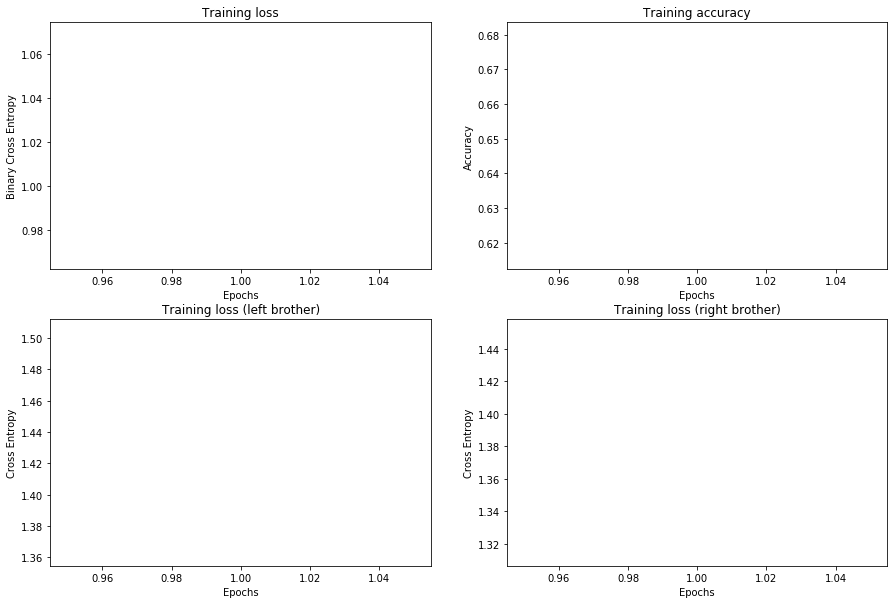

In [48]:
plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
plt.plot(range(1, EPOCHS+1), tr_loss9)
plt.xlabel('Epochs')
plt.ylabel('Binary Cross Entropy')
plt.title('Training loss')

plt.subplot(2,2,2)
plt.plot(range(1, EPOCHS+1), tr_acc9)
plt.title('Training accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.subplot(2,2,3)
plt.plot(range(1, EPOCHS+1), tr_loss9_l)
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy')
plt.title('Training loss (left brother)')

plt.subplot(2,2,4)
plt.plot(range(1, EPOCHS+1), tr_loss9_r)
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy')
plt.title('Training loss (right brother)')

Last test accuracy :0.804


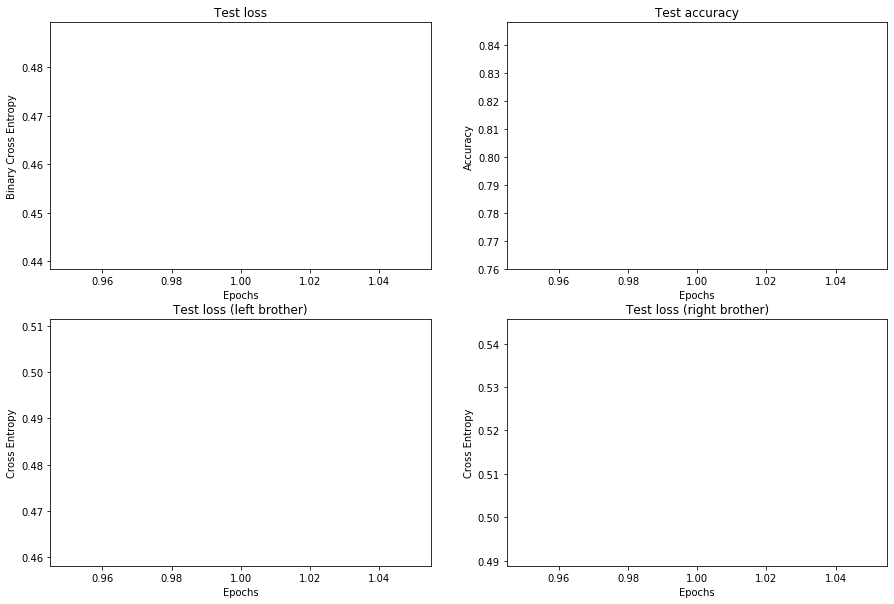

In [49]:
plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
plt.plot(range(1, EPOCHS+1), te_loss9)
plt.xlabel('Epochs')
plt.ylabel('Binary Cross Entropy')
plt.title('Test loss')

plt.subplot(2,2,2)
plt.plot(range(1, EPOCHS+1), te_acc9)
plt.title('Test accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.subplot(2,2,3)
plt.plot(range(1, EPOCHS+1), te_loss9_l)
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy')
plt.title('Test loss (left brother)')

plt.subplot(2,2,4)
plt.plot(range(1, EPOCHS+1), te_loss9_r)
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy')
plt.title('Test loss (right brother)')

print("Last test accuracy :" + str(te_acc9[-1]))